In [1]:
!pip install wandb
!pip install keras_cv

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras_cv
import wandb
import os

from datetime import datetime
from google.colab.patches import cv2_imshow
from wandb.keras import WandbMetricsLogger

Using TensorFlow backend


## Define Hyperparameters

In [3]:
wandb.login()

wandb: Currently logged in as: kristopher-nolte (convector). Use `wandb login --relogin` to force relogin


True

In [4]:
# 3 Rings for the Elven-kings under the sky,
# 7 for the Dwarf-lords in their halls of stone,
# 9 for Mortal Men, doomed to die,
# 1 for the Dark Lord on his dark throne
SEED = 1
DEPICTION = "body"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

species_list = ['AE', 'AL', "JA", 'KO']

# on colab
DIR_PATH = "/content/drive/MyDrive/PhD/WingDatabase/DepictionDataset/{}".format(DEPICTION)
SAVE_DIR = "/content/drive/MyDrive/PhD/WingComparisonStudy/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
IMG_SIZE = 300
BATCH_SIZE = 16
LEARNING_RATE_TRANSFER = 5e-4
LEARNING_RATE_TUNING = 1e-5
MAX_EPOCHS_TRANSFER = 24
MAX_EPOCHS_TUNING = 64
EARLY_STOP_PATIENCE = 12
STEPS_PER_EPOCH = 81
COSINE_DECAY_STEPS = STEPS_PER_EPOCH * MAX_EPOCHS_TUNING
DROPOUT = 0.5

AUG_LAYER = 3
AUG_MAGNITUDE = .05
AUG_ROTATTION = .05
AUG_TRANSLATION = .05
AUG_SHARPNESS = .25
AUG_COLORDEGEN = .25
AUG_NOISE = .1

## Load Dataset

In [7]:
def create_dict(data_split):
    #get a list of image paths defined by the target list
    image_path_dict = {}
    for species in species_list:
        path = DIR_PATH + "/{}/{}/*.png".format(data_split, species)
        image_path_dict[species] = tf.data.Dataset.list_files(path,  shuffle=True, seed=SEED)

    return image_path_dict

def combine_dict(dataset_dict):
  #combine all target_dicts together
  for i,key in enumerate(dataset_dict.keys()):
    if i == 0:
        image_path_ds = dataset_dict[key]
    else:
        image_path_ds = image_path_ds.concatenate(dataset_dict[key])

  return image_path_ds.shuffle(buffer_size=image_path_ds.cardinality())

#create dicts with species as key and tf.ShuffleDataset containing paths as values
train_path_dict = create_dict("train")
val_path_dict = create_dict("val")
test_path_dict = create_dict("test")

#combine dicts to Tensorflow dataset
trainDS_filelist = combine_dict(train_path_dict)
valDS_filelist = combine_dict(val_path_dict)
testDS_filelist = combine_dict(test_path_dict)

In [8]:
for key in train_path_dict.keys():
  print(key, train_path_dict[key].__len__().numpy())

AE 277
AL 278
JA 279
KO 276


## Process Datasets

In [9]:
def getLabel_onehot(file_path):
    # Convert the path to a list of path components
    speciesName = tf.strings.split(file_path, os.path.sep)[-2]
    # get one_hot vector boolean
    species_one_hot = speciesName == species_list
    # cast vector type to integer
    species_one_hot = tf.cast(species_one_hot, dtype=tf.int8, name=None)
    return species_one_hot

def getImage(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, dtype=tf.float32)
    return img

def process_path(file_path):
    species_label = getLabel_onehot(file_path)
    img = getImage(file_path)
    return img, species_label

trainDS_raw = trainDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
valDS_raw = valDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
testDS_raw = testDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

## Initialise Augmentation

In [10]:
randAugment = keras_cv.layers.RandAugment(value_range=(0, 255),
                                           augmentations_per_image=AUG_LAYER,
                                           magnitude=AUG_MAGNITUDE,
                                           geometric=False,
                                           rate=1,
                                           seed=SEED)

#Allowed Geometric Augmentations
randRot = tf.keras.layers.RandomRotation(AUG_ROTATTION, seed=SEED)
randFlip = tf.keras.layers.RandomFlip(mode="horizontal", seed=SEED)
randTrans = tf.keras.layers.RandomTranslation(AUG_TRANSLATION, AUG_TRANSLATION, fill_mode="constant", seed=SEED)

#Colorchanging Augmentations
randSharp = keras_cv.layers.RandomSharpness(AUG_SHARPNESS, value_range=(0, 255), seed=SEED)
randColorDegen = keras_cv.layers.RandomColorDegeneration(AUG_COLORDEGEN, seed=SEED)
randNoise = tf.keras.layers.GaussianNoise(AUG_NOISE)

def augment(img, label):
  img = randRot(img)
  img = randTrans(img)
  img = randFlip(img)
  img = randColorDegen(img)
  img = randAugment(img)
  img = randSharp(img)
  img = randNoise(img)
  return img, label

trainDS = trainDS_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
valDS = valDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
testDS = testDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

batch = next(iter(trainDS))
for i in range(BATCH_SIZE):
  cv2_imshow(batch[0][i].numpy())

Output hidden; open in https://colab.research.google.com to view.

## Initialise Models

In [11]:
def build_model(BASE_MODEL, input_size):
    BASE_MODEL.trainable = False
    #Fully Connected Segment
    flatten_layer = tf.keras.layers.GlobalAveragePooling2D()(BASE_MODEL.output)
    regu_layer = tf.keras.layers.Dropout(DROPOUT)(flatten_layer)
    output_layer = tf.keras.layers.Dense(len(species_list), activation = "softmax")(regu_layer)
    #Built Model
    model = tf.keras.Model(inputs=BASE_MODEL.inputs, outputs=output_layer)
    return model

efficientNETB0_0 = tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3), include_preprocessing=True)

model_dict = {}
model_dict["efficientNETB0"]  = build_model(efficientNETB0_0, IMG_SIZE)

## Transfer Learning

In [12]:
LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
OPTIMIZER_TRANSFER = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE_TRANSFER)
EARLY_STOP = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EARLY_STOP_PATIENCE, mode='auto', restore_best_weights=True)

for model in model_dict:
  wandb.finish()
  model_run = model_run = "_".join([model, "transfer", DEPICTION, str(SEED), datetime.now().strftime('%Y-%m-%d-%H-%M')])
  # Inititiliaze weights&biases
  wandb.init(name=model_run,
             project="comparison",

      # track hyperparameters and run metadata with wandb.config
      config={
          "Model Name": model,
          "Depiction": DEPICTION,
          "Batch Size": BATCH_SIZE,
          "Epochs": MAX_EPOCHS_TRANSFER,
          "Learning Rate": LEARNING_RATE_TRANSFER})

  MONITOR_CALLBACK =  wandb.keras.WandbCallback(save_model=False)

  model_dict[model].compile(optimizer=OPTIMIZER_TRANSFER, loss=LOSS, metrics=["accuracy"])
  history = model_dict[model].fit(trainDS, epochs=MAX_EPOCHS_TRANSFER, validation_data=valDS, callbacks=[EARLY_STOP, MONITOR_CALLBACK])

Epoch 1/24
70/70 [==============================] - 21s 143ms/step - loss: 1.3705 - accuracy: 0.3423 - val_loss: 1.2900 - val_accuracy: 0.4125
Epoch 2/24
70/70 [==============================] - 2s 24ms/step - loss: 1.2583 - accuracy: 0.4234 - val_loss: 1.1998 - val_accuracy: 0.4583
Epoch 3/24
70/70 [==============================] - 2s 24ms/step - loss: 1.1442 - accuracy: 0.4946 - val_loss: 1.1246 - val_accuracy: 0.5250
Epoch 4/24
70/70 [==============================] - 2s 23ms/step - loss: 1.0844 - accuracy: 0.5477 - val_loss: 1.0667 - val_accuracy: 0.5667
Epoch 5/24
70/70 [==============================] - 2s 23ms/step - loss: 1.0248 - accuracy: 0.5991 - val_loss: 1.0282 - val_accuracy: 0.5792
Epoch 6/24
70/70 [==============================] - 2s 24ms/step - loss: 0.9872 - accuracy: 0.6018 - val_loss: 0.9879 - val_accuracy: 0.6083
Epoch 7/24
70/70 [==============================] - 2s 24ms/step - loss: 0.9613 - accuracy: 0.6117 - val_loss: 0.9550 - val_accuracy: 0.6375
Epoch 8/24


## Fine-Tuning

In [13]:
for model in model_dict:
  wandb.finish()
  model_run = model_run = "_".join([model, DEPICTION, str(SEED), datetime.now().strftime('%Y-%m-%d-%H-%M')])
  # Inititiliaze weights&biases
  wandb.init(name=model_run,
             project="comparison",

      # track hyperparameters and run metadata with wandb.config
      config={
          "Model Name": model,
          "Depiction": DEPICTION,
          "Batch Size": BATCH_SIZE,
          "Epochs": MAX_EPOCHS_TUNING,
          "Learning Rate": LEARNING_RATE_TRANSFER,})

  LEARNING_SCHEDUELE = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=LEARNING_RATE_TUNING*0.1,
                                                                 decay_steps=COSINE_DECAY_STEPS,
                                                                 warmup_target=LEARNING_RATE_TUNING,
                                                                 warmup_steps=COSINE_DECAY_STEPS*0.1)

  OPTIMIZER_TUNING = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_SCHEDUELE)

  fine_tune_at = int(len(model_dict[model].layers)*0.5)
  for layer in model_dict[model].layers[fine_tune_at:]:
      if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

  MONITOR_CALLBACK =  wandb.keras.WandbCallback(save_model=False)

  model_dict[model].compile(optimizer=OPTIMIZER_TUNING, loss=LOSS, metrics=["accuracy"])
  history = model_dict[model].fit(trainDS, epochs=MAX_EPOCHS_TUNING, validation_data=valDS, callbacks=[EARLY_STOP, MONITOR_CALLBACK])

  model_dict[model].save(os.path.join(SAVE_DIR, model_run))

accuracy,▁▂▄▅▆▆▆▇▇▆▇▇▇█▇▇████████
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██▇▇██████
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.71261
best_epoch,23
best_val_loss,0.75504
epoch,23
loss,0.73198
val_accuracy,0.70417


Epoch 1/64
70/70 [==============================] - 13s 61ms/step - loss: 0.7015 - accuracy: 0.7333 - val_loss: 0.7347 - val_accuracy: 0.7208
Epoch 2/64
70/70 [==============================] - 2s 35ms/step - loss: 0.6970 - accuracy: 0.7324 - val_loss: 0.7156 - val_accuracy: 0.7208
Epoch 3/64
70/70 [==============================] - 2s 35ms/step - loss: 0.6911 - accuracy: 0.7315 - val_loss: 0.7111 - val_accuracy: 0.7333
Epoch 4/64
70/70 [==============================] - 2s 35ms/step - loss: 0.6543 - accuracy: 0.7432 - val_loss: 0.6969 - val_accuracy: 0.7167
Epoch 5/64
70/70 [==============================] - 2s 36ms/step - loss: 0.6392 - accuracy: 0.7577 - val_loss: 0.6784 - val_accuracy: 0.7292
Epoch 6/64
70/70 [==============================] - 2s 36ms/step - loss: 0.6178 - accuracy: 0.7613 - val_loss: 0.6638 - val_accuracy: 0.7417
Epoch 7/64
70/70 [==============================] - 2s 35ms/step - loss: 0.5874 - accuracy: 0.7838 - val_loss: 0.6418 - val_accuracy: 0.7500
Epoch 8/64
7

In [14]:
def get_cnn_prediction(cnn_model, dataset):
    # Let model predict
    prediction_list = cnn_model.predict(dataset, verbose=0)

    def parse_prediction(prediction_list, rank):
        highest_score_list = [np.sort(prediction)[-rank] for prediction in prediction_list]
        highest_score_index_list = [np.where(prediction_list[i] == highest_score)[0][0] for i, highest_score in enumerate(highest_score_list)]
        species_name_list = [species_list[highest_score_index] for highest_score_index in highest_score_index_list]

        return np.asarray(highest_score_list), np.asarray(species_name_list)

    highest_score_list, species_name_list = parse_prediction(prediction_list, 1)
    sec_highest_score_list, sec_species_name_list = parse_prediction(prediction_list, 2)

    return highest_score_list, species_name_list, sec_highest_score_list, sec_species_name_list, prediction_list

def get_system_prediction(cnn_model, designation, species_list):
    # Load Images
    df_temp = pd.DataFrame(columns=["image_path", "pred_label", "highest_score", "sec_pred_label", "sec_highest_score", "datasplit", "true_label"])
    for species in species_list:
        try:
            folder_path = os.path.join(DIR_PATH, designation, species, "*.png")
            file_list = tf.data.Dataset.list_files(folder_path, shuffle=False)
            dataset = file_list.map(getImage).batch(1)

            # Get Predictions
            highest_score_list, species_name_list, sec_highest_score_list, sec_species_name_list, prediction_list = get_cnn_prediction(cnn_model, dataset)

            df = pd.DataFrame({"image_path": [f.numpy().decode('utf-8') for f in file_list],
                           "pred_label": species_name_list,
                           "highest_score": highest_score_list,
                           "sec_pred_label": sec_species_name_list,
                           "sec_highest_score": sec_highest_score_list,
                               "datasplit": [designation]*file_list.__len__().numpy(),
                               "true_label": [species]*file_list.__len__().numpy(),})

            df_temp = pd.concat([df_temp, df])

        except Exception as e: print(species , e)
    return df_temp

df_dict = {}
for model in model_dict.keys():

    df_val = get_system_prediction(model_dict[model], "val", species_list)
    df_test = get_system_prediction(model_dict[model], "test", species_list)
    df_dict[model] = pd.concat([df_val, df_test])

    df_dict[model]["correct"] = df_dict[model]["pred_label"] == df_dict[model]["true_label"]
    df_dict[model].to_pickle(os.path.join(SAVE_DIR, model_run+"_VALTEST.pkl"))

In [15]:
df_dict[model].groupby("datasplit")["correct"].mean()

datasplit
test    0.779167
val     0.795833
Name: correct, dtype: float64

In [16]:
pd.crosstab(df_dict[model]["true_label"], df_dict[model]["pred_label"])

pred_label,AE,AL,JA,KO
true_label,,,,
AE,103,10,1,6
AL,23,94,3,0
JA,1,1,100,18
KO,18,9,12,81


<Axes: xlabel='true_label'>

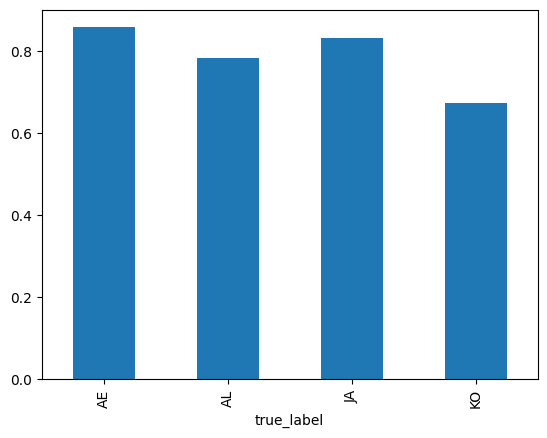

In [17]:
df_dict[model].groupby(["true_label"])["correct"].mean().plot.bar()